# Bài tập về nhà 2: Logistic Regression

Trong bài tập này, các bạn sẽ sử dụng kiến thức đã học về logistic regression để giải quyết bài toán phân lớp, cụ thể là phân loại phương tiện giao thông (xe hơi và xe máy).

## Giới thiệu
Để có thể hoàn tấp bài tập này, các bạn cần nắm rõ những kiến thức sau:
* Logistic regression và nguyên tắc hoạt động.
* Cách lấy đạo hàm cho các tham số trong mô hình trên.
* Giải thuật gradient descent.

Bạn có thể tham khảo lại bài giảng để nắm vững các nội dung này. Ngoài ra, các bạn có thể đặt câu hỏi cho đội ngũ giảng viên nếu có thắc mắc.

Bạn cần giải quyết bài tập này bằng cả **numpy** và **Tensorflow**.

*Lưu ý: để tiện cho việc phân biệt giữa lớp python và lớp trong bài toán phân loại, người viết quy ước rằng khi viết **class** nghiiax là đang nói về python class, khi viết **lớp** nghĩa là đang nói đến lớp của dữ liệu cần phân loại.

## Hướng dẫn nộp bài
Ở mỗi bài tập, các bạn sẽ được yêu cầu điền phần còn thiếu vào trong hàm, các cell để thực hiện phần bài làm sẽ có dòng đầu tiên như sau:
```python
# GRADED FUNCTION: <tên hàm>
...
```
Trong cell đó, các bạn sẽ code phần đáp án của mình giữa 2 phần:
```python
### START CODE HERE ###
<phần bài làm>
### END CODE HERE ###
```
Sau khi thực hiện xong bạn từ terminal, bạn chạy file `submit.py` để nộp bài tập.
```
python submit.py -filepath <PATH_ĐẾN_FILE_BÀI_LÀM_CỦA_BẠN>
```
Mặc định `-filepath` là `2_Logistic_Regression.ipynb`. Nếu bạn không thay đổi tên hoặc vị trí file bài tập. Bạn có thể đơn giản gọi dòng lệnh sau để nộp bài:
```
python submit.py
```
Sau khi chạy dòng lệnh trên, vui lòng điền `username` và `password`, bạn sẽ nhận được kết quả trả về cho bài làm của bạn.

## IMPORT CÁC THƯ VIỆN CẦN THIẾT
Nếu chạy trên máy tính cá nhân, trước hết bạn cần install các thư viện cần thiết bằng cách chạy dòng lệnh sau trong terminal:
```
pip install -r requirements.txt
```
Nếu bạn chạy trên nền tảng Google Colab, bạn có thể bổ qua bước trên.

In [1]:
# IMPORT
import pickle
import numpy as np
import tensorflow as tf
import sys
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
print("Tensorflow version: ", tf.__version__)

Tensorflow version:  2.3.0


## Tải dữ liệu
Các bạn chạy cell bên dưới để tải bộ dữ liệu cũng như các hàm dùng để test cách cài đặt của các bạn:

In [4]:
from google_drive_downloader import GoogleDriveDownloader as gdd
gdd.download_file_from_google_drive(file_id='115H--hHJ1uBASZmCi80WdfN_YtrP7Dzh', dest_path='./assignment2.zip', unzip=True)
!rm assignment2.zip

Unzipping...Done.


Dữ liệu tải xuống của bạn bao gồm:
* File `vehicle.data`: dữ liệu cho bài tập
* File `logistic_unittest.npy`: được dungf để kiểm tra một số hàm mà bạn cài đặt.


In [5]:
!ls assignment2

logistic_unittest.npy  vehicles.dat


## Các hàm bổ trợ dùng để đọc dữ liệu
Nhóm TA sẽ giúp bạn định nghĩa các hàm bổ trợ trong việc đọc dữ liệu, các bạn không cần chỉnh sửa những hàm này.

In [6]:
"""
These functions help you read data from data files.
Author: Kien Huynh
"""


def load_npy(file_name):
    """load_npy
    Load numpy data file. This is needed as python 2.7 pickle uses ascii as default encoding method but python 3.x uses utf-8.abs.

    :param file_name: npy file path
    
    :return obj: loaded numpy object
    """
    
    if (sys.version_info[0] >= 3):
        obj = np.load(file_name, encoding='latin1')
    elif (sys.version_info[0] >=2):
        obj = np.load(file_name)
    
    return obj


def load_list(file_name):
    """load_list
    Load a list object to file_name.

    :param file_name: string, file name
    """
    end_of_file = False
    list_obj = [] 
    f = open(file_name, 'rb')
    python_version = sys.version_info[0]
    while (not end_of_file):
        try:
            if (python_version >= 3):
                list_obj.append(pickle.load(f, encoding='latin1'))
            elif (python_version >=2):
                list_obj.append(pickle.load(f))
        except EOFError:
            end_of_file = True
            print("EOF Reached")

    f.close()
    return list_obj 


def save_list(list_obj, file_name):
    """save_list
    Save a list object to file_name
    
    :param list_obj: List of objects to be saved
    :param file_name: file name.
    """

    f = open(file_name, 'wb')
    for obj in list_obj:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)
    f.close() 


def get_vehicle_data():
    """
    Load vehicle data and return it as a list: [train_x, train_y, test_x, test_y].
    """
    print('Reading vehicle data...')
    train_x, train_y, test_x, test_y = load_list('./assignment2/vehicles.dat')
    train_x = np.transpose(train_x, (2,0,1))
    test_x = np.transpose(test_x, (2,0,1)) 

    print('Done reading')
    return train_x, train_y, test_x, test_y

## Dữ liệu
Tập dữ liệu Vehicles là tập gồm có 2 lớp: xe hơi và xe máy, được gán nhãn lớp 0 (xe hơi) và 1 (xe máy). Ta có thể đọc tập dữ liệu này bằng hàm `get_vehicle_data()`:

In [7]:
train_x, train_y, test_x, test_y = get_vehicle_data()

Reading vehicle data...
EOF Reached
Done reading


Ở đây, `train_x` là một numpy tensor có kích thước `2400 × 64 × 64` (ý nghĩa: tập dữ liệu huấn luyện `train_x` có 2400 mẫu, mỗi mẫu là 1 ảnh có chiều cao (height) và rộng (width) bằng 64).

In [8]:
train_x.shape

(2400, 64, 64)

`train_y` là ma trận chứa nhãn ứng với mẫu dữ liệu trong `train_x`.

In [9]:
train_y.shape

(2400, 1)

Tương tự, test_x có kích thước 600 × 64 × 64, mỗi hàng trong test_y biểu diễn cho nhãn của mỗi mẫu trong test_x.



In [10]:
print(test_x.shape)
print(test_y.shape)

(600, 64, 64)
(600, 1)


Hai tensor `train_x` và `train_y` được dùng cho việc huấn luyện mô hình phân loại; hai tensor `test_x` và `test_y` được dùng cho quá trình đánh giá (test).

Tập dữ liệu này gồm các ảnh xám (gray images), mỗi ảnh chứa một trong hai loại phương tiện di chuyển: xe máy và xe hơi. Mỗi ảnh có thể chứa trọn vẹn hoặc một phần phương tiện. Cần lưu ý là dữ liệu ảnh ở đây chưa được chuẩn hóa, nên các giá trị vẫn nằm trong khoảng từ 0 đến 255.

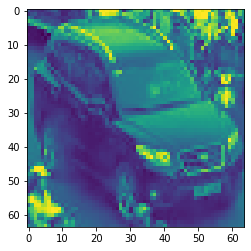

In [11]:
imgplot = plt.imshow(train_x[0])
plt.show()

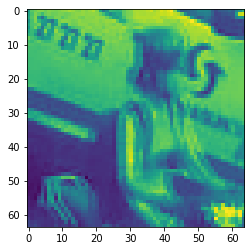

In [12]:
imgplot = plt.imshow(train_x[2399])
plt.show()

## Chuẩn hóa dữ liệu ảnh
Như đã kể trên, ảnh đầu vào có giá trị từ 0 đến 255. Nếu ta đưa trực tiếp bộ ảnh vào quá trình huấn luyện sẽ làm cho gradient lớn. Vì vậy, trước khi huấn luyện, ta có thể sử dụng phương pháp chuẩn hóa dữ liệu để đưa trung bình (mean) của tập train về 0 và độ lệch chuẩn (standard deviation - std) của nó về 1.

Đối với việc xử lý hình ảnh, ta có hai cách chuẩn hóa khác nhau:
*   (a) Xem mỗi pixel trong ảnh là một đặc trưng riêng rẽ. Ví dụ, pixel [1, 3] và pixel [4, 2] là hai đặc trưng khác nhau, được tính mean và std riêng.
*   (b) Xem các pixel khác nhau trong ảnh là cùng 1 loại đặc trưng. Lúc này, pixel [1, 3] và pixel [4, 2] được xem là cùng 1 loại đặc trưng, được tính mean và std chung.

Trong mục này, bạn cần hiện thực cách chuẩn hóa (a) trong hàm ```normalize_per_pixel``` và cách (b) trong hàm ```normalize_all_pixel```. Giả sử ta có ```m``` ảnh train ```x_0..xm−1```, mỗi ảnh train có R hàng và C cột, thì mean và std tính theo cách (a) sẽ là:

\begin{equation}
\overline{x}_{rc}=\frac{1}{m}\sum_{i=0}^{m-1}x_{rc}^{(i)}, 0 \le r \le R-1,0 \le c \le C-1 \tag{1}
\end{equation}

\begin{equation}
\sigma_{rc}=\sqrt{\frac{1}{m}\sum_{i=0}^{m-1}{(x_{rc}^{(i)}-\overline{x}_{rc})^2}} \tag{2}
\end{equation}

Đối với cách (b) ta sẽ có:

\begin{equation}
\overline{x} = \frac{1}{mRC}\sum_{i=0}^{m-1}{\sum_{r=0}^{R-1}{\sum_{c=0}^{C-1}{x_{rc}^{(i)}}}} \tag{3}
\end{equation}

\begin{equation}
\sigma=\sqrt{\frac{1}{mRC}\sum_{i=0}^{m-1}{\sum_{r=0}^{R-1}{\sum_{c=0}^{C-1}{(x_{rc}^{(i)}-\overline{x})^2}}}} \tag{4}
\end{equation}

Sau khi có được mean và std trên toàn bộ data huấn luyện, ta chuẩn hóa các mẫu trong tập huấn luyện theo cách sau:

\begin{equation}
x^{(i)} = \frac{x^{(i)}-\overline{x}}{\sigma} \tag{5}
\end{equation} 

Đối với cách (a), việc này sẽ được áp dụng riêng cho từng pixel trong số $R\times{C}$. Với cách (b), thì ta dùng chung $\overline{x}$ và $\sigma$ trong công thức (3) và (4) cho toàn bộ tất cả các pixel.

Cần lưu ý rằng $\overline{x}$ và $\sigma$ chỉ được tính trên $m$ mẫu dữ liệu huấn luyện. Sau đó, hai giá trị này sẽ được dùng lại để chuẩn hóa các mẫu dữ liệu test (và validation nếu có). Việc tính $\overline{x}$ và $\sigma$ mà có sử dụng các dữ liệu trong tập test là vi phạm nguyên tắc đánh giá các mô hình học máy. 

### TODO 1: normalize_per_pixel (1đ)

In [13]:
# GRADED FUNCTION
def normalize_per_pixel(train_x, test_x):
    """TODO 1: normalize_per_pixel
    This function computes the mean and standard deviation of the pixels located at the same coordinates across and training images
    and performs data scaling on train_x and test_x using these computed values.

    :param train_x: training images, shape=(num_train, image_height, image_width)
    :param test_x: test images, shape=(num_test, image_height, image_width)
    """
    # The shape of train_mean and train_std should be (1, image_height, image_width)
    ### START CODE HERE ### (≈4 lines)
    train_mean = np.mean(train_x, axis=0)
    train_std = np.std(train_x, axis=0)
    train_x = (train_x - train_mean) / train_std
    test_x = (test_x - train_mean) / train_std
    
    ### END CODE HERE ###
    
    return train_x, test_x

In [14]:
### SANITY CHECK
train_x = np.arange(2*2*3).reshape(2,2,3)
assert np.sum(normalize_per_pixel(train_x, train_x)) == 0, "Wrong"

### TODO 2: normalize_all_pixel (1đ)

In [15]:
# GRADED FUNCTION
def normalize_all_pixels(train_x, test_x):
    """TODO 2: normalize_all_pixels
    This function computes the mean and standard deviation of all pixels and performs data scaling on train_x and test_x using these computed values.

    :param train_x: training images, shape=(num_train, image_height, image_width)
    :param test_x: test images, shape=(num_test, image_height, image_width)
    """
    # The shape of train_mean and train_std should be (1, 1, 1).
    ### START CODE HERE ### (≈4 lines)
    train_mean = np.mean(train_x)
    train_std = np.std(train_x)
    train_x = (train_x - train_mean) / train_std
    test_x = (test_x - train_mean) / train_std
    
    ### END CODE HERE ###
    
    return train_x, test_x

In [16]:
### SANITY CHECK
train_x = np.arange(2*2*3).reshape(2,2,3)
assert np.sum(normalize_all_pixels(train_x, train_x)) > 0, "Wrong"

## Duỗi dữ liệu

Dữ liệu ở bước trên vẫn còn ở dạng tensor 3D ($2400 \times 64 \times 64$). Để có thể thực hiện các phép nhân ma trận trong bài toán logistic regression, ta cần chuẩn chúng về dạng tensor 2D ($2400 \times 4096$). Các bạn cần thực hiện bước này trong hàm `reshape2D`.

### TODO 3: reshape2D

In [17]:
# GRADED FUNCTION
def reshape2D(tensor):
    """TODO 3: reshape_2D
    Reshape our 3D tensors to 2D. A 3D tensor of shape (num_samples, image_height, image_width) must be reshaped into (num_samples, image_height*image_width).
    """
    result = None
    ### START CODE HERE ### (≈1 line)
    result = tensor.reshape(tensor.shape[0], tensor.shape[1] * tensor.shape[2])
    ### END CODE HERE ###
    return result

In [18]:
### SANITY CHECK
tensor = np.arange(2*3*4).reshape(2,3,4)
assert sum(reshape2D(tensor).shape)==14, "Wrong"

## Thêm đặc trưng 1 vào dữ liệu
Để tính tích vô hướng dễ dàng, nối thêm một cột có giá trị bằng 1 vào `train_x` và `test_x` (concatenate có axis=1). Trong file có sẵn hàm `add_one` và ta nên thực hiện code trong hàm này. Sau bước này, dữ liệu huấn luyện sẽ có kích thước $2400 \times 4097$.

### TODO 4: add_one

In [19]:
# GRADED FUNCTION
def add_one(x):
    """TODO 4: add_one
    This function add ones as an additional feature for x.

    :param x: input data
    """
    ### START CODE HERE ### (≈1 line)
    x = np.concatenate((x, np.ones((x.shape[0], 1))), axis=1)
    ### END CODE HERE ###
    return x

In [20]:
### SANITY CHECK
x = np.arange(2*3).reshape(2,3)
assert add_one(x).sum() == 17, "Wrong"

## Class LogisticClassifier: Logistic Regression với numpy

Nhằm hỗ trợ cho việc lập trình, đội ngũ TA cung cấp sẵn cho các bạn class **LogisticClassifier**. Một trong các thành phần chính của class LogisticClassifier là `w`, tham số mà ta cần tìm khi huấn luyện. Tham số này là một mảng có số hàng bằng số đặc trưng của dữ liệu đầu vào, số cột bằng 1. Cụ thể trong bài toán phân loại ảnh xe này, `w` sẽ là một ma trận $4097\times{1}$. `w` được khởi tạo ngẫu nhiên trong hàm `__init__(w_shape)`. Để truy xuất `w` từ bên trong class, ta dùng `self.w`, ví dụ:
```python
class logistic_classifier(object):
    def feed_forward(self, x):
        print(self.w)
```

Để truy xuất w từ bên ngoài class, ta cần có một thực thể của class và gọi thông qua thực thể này, ví dụ:
```python
if __name__ == "__main__":
    num_feature = train_x.shape[1]
    bin_classifier = LogisticClassifier((num_feature, 1))
    print(bin_classifier.w)
```

Đối với các hàm thuộc class **LogisticClassifier**, việc truy xuất cũng hoàn toàn giống với `w`. Chúng sẽ được mô tả chi tiết trong mục tiếp theo.

In [21]:
# GRADED FUNCTION
class LogisticClassifier(object):
    def __init__(self, w_shape):
        """__init__
        
        :param w_shape: create w with shape w_shape using normal distribution
        """

        mean = 0
        std = 1
        self.w = np.random.random(w_shape)


    def feed_forward(self, x):
        """TODO 5: feed_forward
        This function computes the output of your logistic classification model.
        
        :param x: input
        """
        result = None
        
        ### START CODE HERE ### (≈2 lines)
        z = np.dot(x, self.w)
        result = 1 / (1 + np.exp(-z))
        ### END CODE HERE ###
        
        return result


    def compute_loss(self, y, y_hat):
        """TODO 6: compute_loss
        Compute the loss using y (label) and y_hat (predicted class).

        :param y:  the label, the actual class of the sample
        :param y_hat: the probabilities that the given sample belong to class 1
        """
        loss = 0
        
        ### START CODE HERE ### (≈2 lines)
        m = y_hat.shape[0]
        loss = - 1 / m * (np.sum(y * np.log(y_hat) + (1 - y) * np.log(1 - y_hat)))
        ### END CODE HERE ###
        
        return loss


    def get_grad(self, x, y, y_hat):
        """TODO 7: get_grad
        Compute and return the gradient of w.

        :param x: input
        :param y: the label, the actual class of the sample data
        :param y_hat: predicted y
        """ 
        w_grad = None
        
        ### START CODE HERE ### (≈2 lines)
        m = y_hat.shape[0]
        w_grad = 1 / m * np.dot(x.T, (y_hat - y))
        ### END CODE HERE ###
        
        return w_grad


    def update_weight(self, grad, learning_rate):
        """TODO 8: update_weight
        Update w using the computed gradient.

        :param grad: gradient computed from the loss
        :param learning_rate: float, learning rate
        """
        ### START CODE HERE ### (≈1 line)
        self.w = self.w - learning_rate * grad
        ### END CODE HERE ###
        return self.w


    def update_weight_momentum(self, grad, learning_rate, momentum, momentum_rate):
        """TODO 9: update_weight using momentum
        BONUS:[YC1.8]
        Update w using the algorithm with momentum

        :param grad: gradient computed from the loss
        :param learning_rate: float, learning rate
        :param momentum: the array storing momentum for training w, should have the same shape as that of w
        :param momentum_rate: float, how much momentum to reuse after each loop (denoted as gamma in the following section)
        """
        ### START CODE HERE ### (≈3 lines)
        momentum = momentum_rate * momentum + learning_rate * grad
        self.w = self.w - momentum
        ### END CODE HERE ###
        return self.w


    def numerical_check(self, x, y, grad):
        eps = 0.000005
        w_test0 = np.copy(self.w)
        w_test1 = np.copy(self.w)
        w_test0[2] = w_test0[2] - eps
        w_test1[2] = w_test1[2] + eps

        y_hat0 = np.dot(x, w_test0)
        y_hat0 = 1. / (1. + np.exp(-y_hat0))
        loss0 = self.compute_loss(y, y_hat0) 

        y_hat1 = np.dot(x, w_test1)
        y_hat1 = 1. / (1. + np.exp(-y_hat1))
        loss1 = self.compute_loss(y, y_hat1) 

        numerical_grad = (loss1 - loss0)/(2*eps)
        print(numerical_grad)
        print(grad[2])

In [22]:
### SANITY CHECK
eps = 0.001        
classifer = LogisticClassifier((3,1))
classifer.w = np.arange(3*1).reshape(3,1)
x = np.ones(2*3).reshape(2,3)
y = np.ones(2).reshape(2,1)
y_hat = classifer.feed_forward(x)
assert abs(sum(y_hat) - 1.905) < eps, "Wrong"
loss = classifer.compute_loss(y, y_hat)
assert abs(loss - 0.048) < eps, "Wrong"
grad = classifer.get_grad(x, y, y_hat)
assert abs(sum(grad) + 0.142) < eps, "Wrong"
updateweight = classifer.update_weight(grad, 0.1)
assert abs(sum(updateweight) - 3.014) < eps, "Wrong"
updatemomen = classifer.update_weight_momentum(grad, 0.1, 0.1, 0.1)
assert abs(sum(updatemomen) - 2.998) < eps, "Wrong"

### Tính các giá trị phân loại

Các giá trị phân loại, $\hat{y}$, sẽ được tính trong hàm `feed_forward` của class `LogisticClassifier`. Công thức tính như sau:

\begin{equation}
z = xw  \tag{6}
\end{equation}
\begin{equation}
\hat{y} = \frac{1}{1+e^{-z}} \tag{7}
\end{equation}

Ở đây, $w = [w_0, w_1,.., w_{4096}]^T$ là các tham số cần học (lưu trong biến `self.w` trong class `LogisticClassifier`). Lẽ ra công thức (6) được viết là $z=xw+w_{4096}$, tuy nhiên ở bước trên ta đã thêm 1 vào làm đặc trưng cuối cho tất cả các mẫu. Việc này giúp cho quá trình nhân ma trận và quản lý các biến gọn hơn.

#### TODO 5: feed_forward
Các bạn hoàn thành hàm `feed_forward()` trong class `LogisticClassifier` ở trên

### Tính độ lỗi

Việc tính độ lỗi được thực hiện trong hàm `compute_loss` của class `LogisticClassifier`. Công thức tính độ lỗi như sau:

\begin{equation}
J(w) = -\frac{1}{m}\sum_{i=0}^{m-1}(y^{(i)}\log{\hat{y}^{(i)}} + (1-y^{(i)})\log(1-\hat{y}^{(i)})) \tag{8}
\end{equation}

Trong đó:
-  $y^{(i)}$ là nhãn của mẫu thứ $i$, mẫu thuộc lớp 0 sẽ có $y^{(i)}=0$, mẫu thuộc lớp 1 sẽ có $y^{(i)}=1$. Ta có thể truy cập các nhãn này thông qua biến `train_y` và `test_y`.
- $\hat{y}^{(i)} \in (0, 1)$ là phần tử thứ $i$ trong vector $\hat{y}$.
- $m=2400$ là tổng số mẫu huấn luyện.


Để tính trung bình trên ma trận theo hàng hoặc cột, ta có thể sử dụng hàm `np.mean()` với tham số axis tương ứng.

#### TODO 6: compute_loss
Các bạn hoàn thành hàm `compute_loss()` trong class `LogisticClassifier` ở trên.

### Tính đạo hàm
Để tính đạo hàm riêng cho thành phần $w_j$ trong $w$ trong hàm `get_grad`, ta dùng công thức sau:
\begin{equation}
\frac{\partial  J(w_j)}{\partial w_j} = \frac{1}{m}\sum_{i=1}^{m}(\hat{y}^{(i)} - y^{(i)})x^{(i)}_j \tag{9}
\end{equation}

Trong trường hợp này, sau khi thêm 1 vào `train_x` thì ta sẽ có $0 \le j \le 4096$.

#### TODO 7: get_grad
Các bạn hoàn thành hàm `get_grad()` trong class `LogisticClassifier` ở trên.

### Cập nhật $w$
Để huấn luyện được mô hình phân loại trong hàm `update_weight`, ta cần cập nhật $w$ theo công thức sau:
\begin{equation}
w = w - \alpha\times\frac{\partial  J(w)}{\partial w} \tag{10}
\end{equation}

Với $\alpha$ là hệ số học (`learning_rate`).

#### TODO 8: update_weight
Các bạn hoàn thành hàm `update_weight()` trong class `LogisticClassifier` ở trên.

### Cập nhật $w$ dùng momentum

Giải thuật cập nhật trình bày trong phần trước có điểm yếu là chậm và dễ rơi vào tối ưu cục bộ. Tuy trong bài này, giải thuật đó cũng đủ để giải quyết, nhưng ta vẫn có thể sử dụng giải thuật có quán tính để việc huấn luyện diễn ra nhanh hơn.

Khởi tạo ma trận quán tính trước khi vào vòng lặp chính:
\begin{equation}
\Delta w = 0 \tag{11}
\end{equation}

Ở đây, $\Delta w$ là ma trận có kích thước bằng chính kích thước của $w$. Quá trình cập nhật $w$ sẽ được diễn ra như sau:
\begin{equation}
\Delta w = \gamma\Delta w + \alpha\frac{\partial  J(w)}{\partial w} \tag{12}
\end{equation}

\begin{equation}
w = w - \Delta w \tag{13}
\end{equation}

Với $\gamma$ là hệ số quán tính (thường được đặt là 0.9).

#### TODO 9: update_weight_momentum
Các bạn hoàn thành hàm `update_weight_momentum` vào class `LogisticClassifier` ở trên.

### Đánh giá mô hình phân loại
Để đánh giá mô hình phân loại trên tập kiểm thử (`test_x` và `test_y`), trước tiên, ta cần thực hiện tính các giá trị phân loại trên`test_x`. Sau khi đã có các giá trị này, ta sử dụng các tiêu chí sau để đánh giá mô hình:

\begin{equation}
Precision = \frac{TP}{TP+FP} \tag{14}
\end{equation}

\begin{equation}
Recall = \frac{TP}{P} \tag{15}
\end{equation}

\begin{equation}
F_1-score = 2\times\frac{Precision\times Recall}{Precision+Recall} \tag{16}
\end{equation}

Trong đó:
- Lớp positive là lớp có giá trị y = 1.
- TP (true positive) là tổng số các mẫu mà mô hình dự đoán là positive. ($\hat{y}=1$) và thực sự có nhãn là positive ($y=1$).
- FP (false positive) là tổng số các mẫu mô hình dự đoán là positive($\hat{y}=1$) nhưng thực chất có nhãn là negative ($y=0$).
- P là tổng số mẫu positive trong tập test.

Nhiệm vụ của bạn trong bước này là tính các thông số trên trong hàm `test`. Khi tiến hành kiểm thử, người ra đề đã tính được các giá trị $Precision=0.766$, $Recall=0.830$ và $F_1-score=0.797$. Bạn hãy cố gắng hoàn thiện bài làm của mình để đạt kết quả tương tự hoặc tốt hơn.

#### TODO 10: test

In [23]:
# GRADED FUNCTION
def test(y_hat, test_y, thres=0.5):
    """TODO 10: test
    Compute precision, recall and F1-score based on predicted test values

    :param y_hat: predicted values, output of classifier.feed_forward
    :param test_y: test labels
    """
    
    # Compute test scores using test_y and y_hat

    precision = 0
    recall = 0
    f1 = 0
    ### START CODE HERE ### (≈7 lines)
    predict = lambda x: 1 if x > thres else 0
    predict_vectorize = np.vectorize(predict)
    predicted_y = predict_vectorize(y_hat)

    TP = np.sum(np.logical_and(predicted_y == 1, test_y == 1))
    FP = np.sum(np.logical_and(predicted_y == 1, test_y == 0))
    FN = np.sum(np.logical_and(predicted_y == 0, test_y == 1))
    
    precision = TP / (TP + FP)
    recall = TP / (TP + FN)
    f1 = 2 * (precision * recall) / (precision + recall)
    ### END CODE HERE ###

    return precision, recall, f1

In [24]:
### SANITY CHECK
y_hat = np.array([0.4, 0.7, 0.8, 0.3, 0.2])
test_y = np.array([0, 1, 1, 0, 0])
#assert sum(test(y_hat, test_y)) == 3, "Wrong"
print(test(y_hat, test_y))

(1.0, 1.0, 1.0)


### Vòng lặp huấn luyện

Vòng lặp của quá trình huấn luyện được xây dựng trong đoạn code sau đây. Tất cả khung sườn cho việc thực thi đã được lập trình sẵn. Ta có thể thay đổi hai tham số tác động đến quá trình huấn luyện như sau:

- `num_epoch`: số lượng vòng lặp cho quá trình huấn luyện.
- `learning_rate`: hệ số học $\alpha$.
- `momentum_rate`: hệ số momentum $\gamma$.
- `epochs_to_draw`: số lượng epochs cần đạt được để vẽ đồ thị độ lỗi trong lúc huấn luyện.

In [25]:
def plot_loss(all_loss):
    plt.figure(1)
    plt.clf()
    plt.plot(all_loss)

Reading vehicle data...
EOF Reached
Done reading


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: RuntimeWarning: overflow encountered in exp
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:41: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in multiply


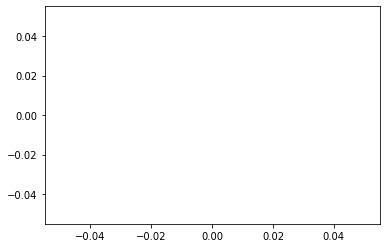

Epoch 1000: loss is nan


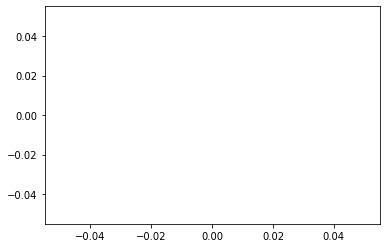

Epoch 2000: loss is nan


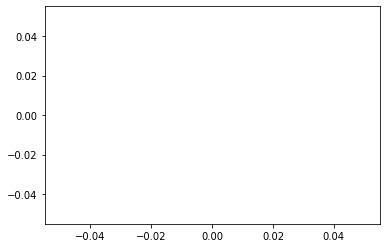

Epoch 3000: loss is nan


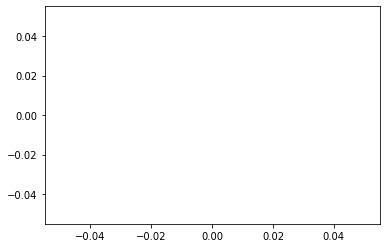

Epoch 4000: loss is nan


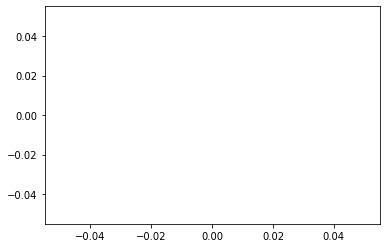

Epoch 5000: loss is nan


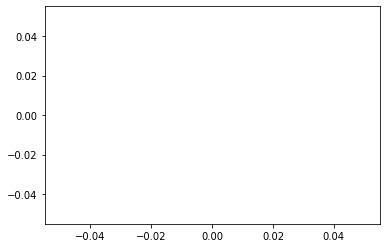

Epoch 6000: loss is nan


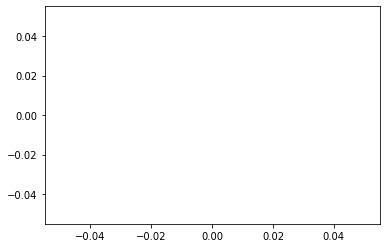

Epoch 7000: loss is nan


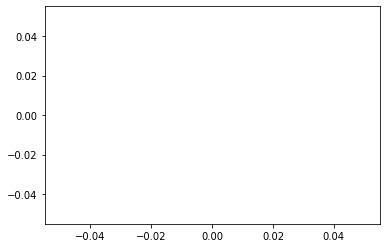

Epoch 8000: loss is nan


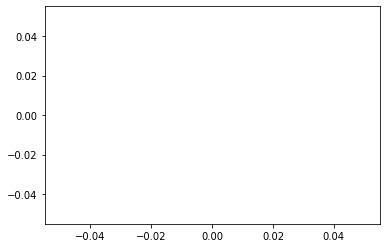

Epoch 9000: loss is nan


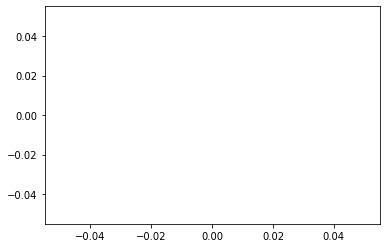

Epoch 10000: loss is nan
Precision: 0.714
Recall: 0.767
F1-score: 0.740


In [30]:
#@title Training { display-mode: "both" }
normalize_method = "per_pixel" #@param ["all_pixels", "per_pixel"]
update_weight_method = "momentum" #@param ["normal", "momentum"]
num_epoch = 10000 #@param {type:"integer"}
learning_rate = 0.1 #@param {type:"number"}
momentum_rate = 0.9 #@param {type:"number"}
epochs_to_draw = 1000 #@param {type:"integer"}

np.random.seed(2020)

# Load data from file
# Make sure that vehicles.dat is in data/
train_x, train_y, test_x, test_y = get_vehicle_data()
num_train = train_x.shape[0]
num_test = test_x.shape[0]

# Normalize our data: choose one of the two methods before training
if normalize_method == "all_pixels":
    train_x, test_x = normalize_all_pixels(train_x, test_x) 
else:
    train_x, test_x = normalize_per_pixel(train_x, test_x) 

# Reshape our data
# train_x: shape=(2400, 64, 64) -> shape=(2400, 64*64)
# test_x: shape=(600, 64, 64) -> shape=(600, 64*64)
train_x = reshape2D(train_x)
test_x = reshape2D(test_x)

# Pad 1 as the last feature of train_x and test_x
train_x = add_one(train_x) 
test_x = add_one(test_x)

# Create classifier
num_feature = train_x.shape[1]
bin_classifier = LogisticClassifier((num_feature, 1))
momentum = np.zeros_like(bin_classifier.w)

# Define hyper-parameters and train-related parameters
all_loss = []
plt.ion()
for e in range(num_epoch):    
    y_hat = bin_classifier.feed_forward(train_x)
    loss = bin_classifier.compute_loss(train_y, y_hat)
    grad = bin_classifier.get_grad(train_x, train_y, y_hat)

    # Updating weight: choose either normal SGD or SGD with momentum
    if update_weight_method == "normal":
        bin_classifier.update_weight(grad, learning_rate)
    else: 
        bin_classifier.update_weight_momentum(grad, learning_rate, momentum, momentum_rate)

    all_loss.append(loss) 

    if (e % epochs_to_draw == epochs_to_draw-1):
        plot_loss(all_loss)
        plt.show()
        plt.pause(0.1)     
        print("Epoch %d: loss is %.5f" % (e+1, loss))

y_hat = bin_classifier.feed_forward(test_x)
precision, recall, f1 = test(y_hat, test_y)
print("Precision: %.3f" % precision)
print("Recall: %.3f" % recall)
print("F1-score: %.3f" % f1)

## Class LogisticRegressionTF: Logistic regression với Tensorflow
Chúng ta sử dụng tensorflow eager execution để cài đặt mô hình logistic regression. Với tf eager execution, giá trị của các biến được tính toán ngay lập tức thay vì xây dựng computational graph để chạy sau đó. Một trong những lợi ích thiết thực nhất là giúp chúng ta dễ dàng debug mô hình, xây dựng được dynamic model.

Để xây dựng mô hình bằng eager execution, chúng ta thường định nghĩa một lớp đối tượng như mình họa ở dưới.

Chúng ta kế thừa lớp Model và cài đặt 2 hàm chính:
- init: khởi tạo tất cả các tham số. 
- call: hàm dùng cho feedforward.

In [ ]:
class LogisticRegressionTF(tf.keras.Model):

    def __init__(self, num_class):
        super(LogisticRegressionTF, self).__init__()
        # init all weights here
        self.dense = tf.keras.layers.Dense(num_class)

    def call(self, inputs, training=None, mask=None):
        output = self.dense(inputs)
        
        output = tf.nn.softmax(output)        
        return output

### TODO 11: Định nghĩa one-hot encoder

In [ ]:
# GRADED FUNCTION
def create_one_hot(labels, num_k=10):
    """TODO 11: create_one_hot
    This function creates a one-hot (one-of-k) matrix based on the given labels.

    :param labels: list of labels, each label is one of 0, 1, 2,... , num_k - 1
    :param num_k: number of classes we want to classify
    """
    eye_mat = None
    ### START CODE HERE ### (≈2 lines)
    eye = np.eye(num_k)
    eye_mat = eye[labels]
    ### END CODE HERE ###
    return eye_mat

In [ ]:
### SANITY CHECK
x = [1, 2, 3]
y = create_one_hot(x, 4)
assert y.shape == (3,4), "Wrong"
assert sum(np.argmax(y, axis=0)) == 3, "Wrong"

### Huấn luyện mô hình với Tensorflow

In [ ]:
#@title Training { display-mode: "both" }
normalize_method = "per_pixel" #@param ["all_pixels", "per_pixel"]
num_epoch =  2000#@param {type:"integer"}
learning_rate = 0.001 #@param {type:"number"}
batch_size = 32
num_classes = 2
np.random.seed(2020)
tf.random.set_seed(2020)

# Load data from file
# Make sure that vehicles.dat is in data/
train_x, train_y, test_x, test_y = get_vehicle_data()
num_train = train_x.shape[0]
num_test = test_x.shape[0]  

#generate_unit_testcase(train_x.copy(), train_y.copy()) 
#logistic_unit_test()

# Normalize our data: choose one of the two methods before training
if normalize_method == "all_pixels":
    train_x, test_x = normalize_all_pixels(train_x, test_x) 
else:
    train_x, test_x = normalize_per_pixel(train_x, test_x) 

# Reshape our data
# train_x: shape=(2400, 64, 64) -> shape=(2400, 64*64)
# test_x: shape=(600, 64, 64) -> shape=(600, 64*64)
train_x = reshape2D(train_x)
test_x = reshape2D(test_x)
train_y = create_one_hot(train_y.astype('int32').flatten().tolist(), num_k=2)
test_y = create_one_hot(test_y.astype('int32').flatten().tolist(), num_k=2)

device = '/cpu:0' if len(tf.config.experimental.list_physical_devices('GPU')) == 0 else '/gpu:0'

with tf.device(device):
    # build model and optimizer
    model = LogisticRegressionTF(num_classes)
    model.compile(optimizer=tf.optimizers.Adam(learning_rate), loss='binary_crossentropy',
                  metrics=['accuracy'])
    

    # train
    model.fit(train_x, train_y, batch_size=batch_size, epochs=num_epoch,
              validation_data=(test_x, test_y), verbose=2)

    # evaluate on test set
    scores = model.evaluate(test_x, test_y, 32, verbose=2)
    
    y_hat = model.predict(test_x)
    precision, recall, f1 = test(y_hat, test_y)
    print("Precision: %.3f" % precision)
    print("Recall: %.3f" % recall)
    print("F1-score: %.3f" % f1)

Reading vehicle data...
EOF Reached
Done reading
Epoch 1/2000
75/75 - 0s - loss: 0.4585 - accuracy: 0.8242 - val_loss: 0.6015 - val_accuracy: 0.7700
Epoch 2/2000
75/75 - 0s - loss: 0.3102 - accuracy: 0.8821 - val_loss: 0.7007 - val_accuracy: 0.7417
Epoch 3/2000
75/75 - 0s - loss: 0.2784 - accuracy: 0.8896 - val_loss: 0.6857 - val_accuracy: 0.7433
Epoch 4/2000
75/75 - 0s - loss: 0.2317 - accuracy: 0.9075 - val_loss: 0.7339 - val_accuracy: 0.7633
Epoch 5/2000
75/75 - 0s - loss: 0.1979 - accuracy: 0.9200 - val_loss: 0.6180 - val_accuracy: 0.7867
Epoch 6/2000
75/75 - 0s - loss: 0.1731 - accuracy: 0.9296 - val_loss: 0.7129 - val_accuracy: 0.7667
Epoch 7/2000
75/75 - 0s - loss: 0.1513 - accuracy: 0.9458 - val_loss: 0.6867 - val_accuracy: 0.7567
Epoch 8/2000
75/75 - 0s - loss: 0.1342 - accuracy: 0.9513 - val_loss: 0.7239 - val_accuracy: 0.7717
Epoch 9/2000
75/75 - 0s - loss: 0.1425 - accuracy: 0.9429 - val_loss: 0.8153 - val_accuracy: 0.7500
Epoch 10/2000
75/75 - 0s - loss: 0.1273 - accuracy: